Number of unique categories: 24
Number of unique web services: 141


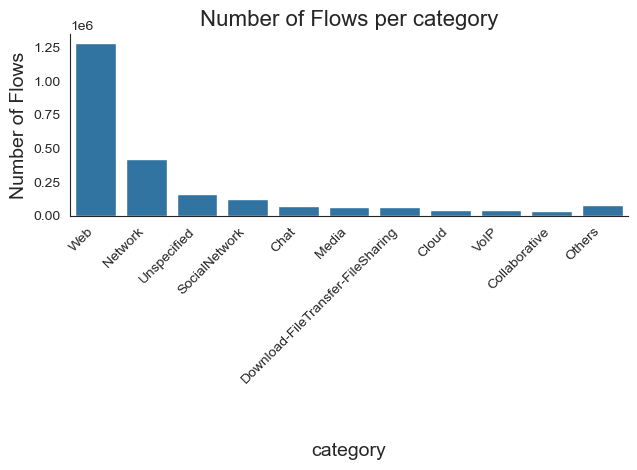

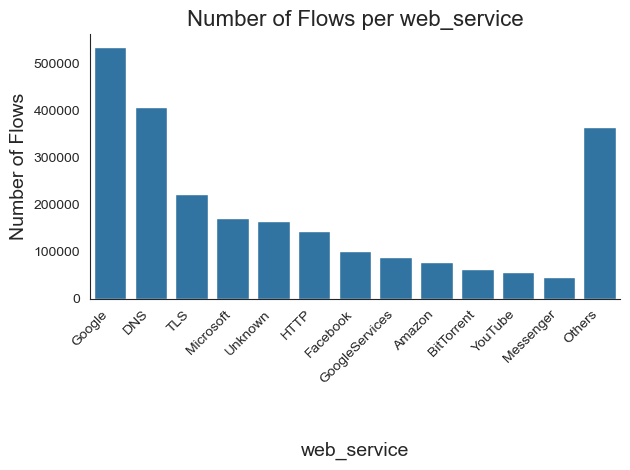

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.compat import open_latin1

file_path = "../../web_service_dataset.csv"
df = pd.read_csv(file_path)
# 1.1
unique_categories = df['category'].unique()
unique_web_services = df['web_service'].unique()

print(f"Number of unique categories: {len(unique_categories)}")
print(f"Number of unique web services: {len(unique_web_services)}")

df_categories = ['category', 'web_service']
threshold = 25000

for elem in df_categories:
    flow_by_elem = df.groupby(elem)['flow_key'].nunique().sort_values(ascending=False)
    small_values = flow_by_elem[flow_by_elem < threshold].sum()
    flow_by_elem = flow_by_elem[flow_by_elem >= threshold]
    if small_values > 0:
        flow_by_elem["Others"] = small_values
    sns.set_style("white")
    sns.barplot(x=flow_by_elem.index, y=flow_by_elem.values)
    plt.title(f'Number of Flows per {elem}', fontsize=16)
    plt.xlabel(f'{elem}', fontsize=14, labelpad=40)
    plt.ylabel("Number of Flows", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.tight_layout()
    plt.show()
    

In [107]:
# 1.2
from sklearn.preprocessing import LabelEncoder

# How many unique protocols are there in the dataset?
unique_proto = df['proto'].unique()
    
print(f"Number of unique proto: {len(unique_proto)}")

# Convert such a categorical feature into a numerical one through one-hot encoding.
one_hot_proto = pd.get_dummies(df['proto'], prefix='proto')

# Convert string labels (category and web service) into numerical classes.

label_encoder_category = LabelEncoder()
label_encoder_service = LabelEncoder()
category_numerical_class = label_encoder_category.fit_transform(df['category'])
web_service_numerical_class = label_encoder_service.fit_transform(df['web_service'])

print(category_numerical_class)
print(web_service_numerical_class)

Number of unique proto: 3
[11 11 11 ... 18 23 23]
[17 17 17 ... 64 31 31]


In [146]:
# 1.3

# Do you find features that only have a constant value?

numeric_df = df.select_dtypes(include=['number']) 
constant_features = [col for col in numeric_df if numeric_df[col].std() == 0]

print(f"Constant features: {constant_features}")

if len(constant_features) > 0:
    df = df.drop(columns=constant_features)
    
# Do you find features that have low variance? If yes, do you think whether we should remove them or not?

numeric_var = numeric_df.var().mean()

numeric_std = numeric_df.std().mean()

print(f"Average Variance: {numeric_var}")

print(f"Average Standard deviation: {numeric_std}")

low_var = 0.000001 * numeric_var

low_variance_features = [col for col in numeric_df if numeric_df[col].var() < low_var]

high_variance_features = [col for col in numeric_df if numeric_df[col].var() > low_var]

num_of_low_variance = len(low_variance_features)

num_of_high_variance = len(high_variance_features)

print(f"Low variance features: {num_of_low_variance}")

print(f"High variance features: {num_of_high_variance}")

# With low variance we couldn't understand if information of this object will be significant for the training


Constant features: []
Average Variance: 2.728525993029358e+22
Average Standard deviation: 35242034569.43971
Low variance features: 40
High variance features: 4


In [82]:
df

,flow_key,src_ip_numeric,src_ip,src_port,dst_ip,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,...,proto_17,proto_1,proto_6,proto_17,proto_1,proto_6,proto_17,proto_1,proto_6,proto_17
0,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,22,7620,328,...,True,False,False,True,False,False,True,False,False,True
1,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,17,5670,328,...,True,False,False,True,False,False,True,False,False,True
2,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,43,15124,328,...,True,False,False,True,False,False,True,False,False,True
3,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,30,10086,328,...,True,False,False,True,False,False,True,False,False,True
4,cfa7c2740072befaa89c202499729e08,3232266497,192.168.121.1,0,10.130.1.166,0,1,1,56,56,...,False,True,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704834,695ea899a18c6d2f90c8b2f6c9b70bdf,3232268540,192.168.128.252,137,172.16.255.186,137,17,9,702,78,...,True,False,False,True,False,False,True,False,False,True
2704835,f8188e4364129e635fe032a3bda206ea,3232268540,192.168.128.252,138,172.16.255.185,138,17,3,687,229,...,True,False,False,True,False,False,True,False,False,True
2704836,4deda0130e2054781655cb4bd4cb580d,3232268540,192.168.128.252,138,172.16.255.186,138,17,3,687,229,...,True,False,False,True,False,False,True,False,False,True
2704837,8c07a45c0c48648ff56341d7a065b855,3232268540,192.168.128.252,49879,108.177.11.188,5228,6,75,3520,40,...,False,False,True,False,False,True,False,False,True,False
